This first bit of code takes care of a few things. First, it gets some of the necessary imports out of the way and sets print options. Then, it reads in the sequence csv file and filters out unnecessary columns, leaving 7 total features:

1.   The position of the packet within its sequence. This is used only to parse the csv file back out into sequences.
2.   The timestamp of the packet
3.   The source IP
4.   The destination IP
5.   The packet length
6.   The source port
7.   The destination port



In [1]:
import pandas as pd
import numpy as np
import time
import os
import random
import psutil

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Read the data and filter out unnecessary columns
data = pd.read_csv("SequenceCSV.csv", delimiter=',', header=0)
data = data.filter(items=['Position','Time','Source IP','Destination IP','Length','Source Port','Destination Port'])
print(data)
#num_sequences = data.Position.value_counts()[0]
#print(num_sequences)

        Position          Time       Source IP  Destination IP  Length  Source Port  Destination Port
0              0     37.294817  172.16.113.105   196.37.75.158      60           79              1024
1              1     37.295017   196.37.75.158  172.16.113.105      60         1024                79
2              2     37.295563   196.37.75.158  172.16.113.105      60         1024                79
3              3     37.307251  172.16.113.105   196.37.75.158      60           79              1024
4              4     37.327150  172.16.113.105   196.37.75.158      60           79              1024
...          ...           ...             ...             ...     ...          ...               ...
465100         3  25253.689350  172.16.112.207   194.27.251.21      60        15901                23
465101         0  25253.710980  197.182.91.233   172.16.114.50      60         8803                23
465102         1  25253.779420  172.16.112.207   194.27.251.21      60        1590

# Dictionary

This class is used for data storage and representation, treating each packet as a word might be treated in a language translation application. Each "token" (or packet) of a sequence is represented as a one-hot encoded vector, where the index of the packet in the dictionary is used to generate the vector. 

The token2index dictionary allows the user to access the index of a given packet, while the index2token dictionary allows the inverse. The index2token dictionary also has hard-coded indexes for the start of connection (SOC) and end of connection (EOC) tokens. The token2count dictionary stores the frequency of each token in the overall dataset, which could prove useful to anomaly detection. The dictionary also stores the total number of individual tokens.

This class has two functions:

1.   add_sequence - splits a sequence into tokens and adds them to the dictionary
2.   add_token - adds a token to the Dict by updating the necessary dictionaries

This class will be used to build an input dictionary, which deals with the input sequences, and a target dictionary, which deals with the target (or predicted) sequences.

In [0]:
class Dict:
    def __init__(self, name):
        self.name = name
        self.token2index = {}
        self.token2count = {}
        self.index2token = {0: "SOC", 1: "EOC"}
        self.n_tokens = 2  # 2 by default because of SOC/EOC

    def add_sequence(self, sequence): # Split the sequence and add the tokens to the dict
        for token in sequence.split(' '):
            self.add_token(token)

    def add_token(self, token): # Add a token to the dict
        if token not in self.token2index:
            self.token2index[token] = self.n_tokens
            self.token2count[token] = 1
            self.index2token[self.n_tokens] = token
            self.n_tokens += 1
        else:
            self.token2count[token] += 1

# Data preparation
The purpose of data preparation in this application is to get the data ready to put into a format that the model can read. In the case of an application using pytorch, the data must be stored as tensors. But first, a few default values must be assigned for later on. The SOC and EOC tokens are initialized and given indexes, and a maximum sequence length is defined. For now, the only feature being considered is the source IP, but this will obviously change going forward.

### Getting the sequences
In order to do this, we need to split each connection into input and target sequences where the input sequence is the first 3 packets of a connection and the target sequence is the rest of the connection. This is handled via the split_sequence function and the sequence_to_string function. First the sequence_to_string function converts the entire connection into a whitespace delimited string, then the split_sequence function separates it into input and target sequences.

### Creating the pairs
The read_dict function serves as a bit of an overhead for the previous two functions. It will loop through all of the sequences and call the previous functions to split them up into input, target pairs and initialize the input and target Dicts. Finally, the prepare_data function collapses all of the previous functions into a single one, reading the dictionaries and pairs from a call to read_dicts and then filling out the dictionaries by adding the input and target sequences. 

To make sure that all of this is working correctly, a random [input, target] pair is printed once the data is prepared.


In [3]:
# Start and end of connection tokens
SOC_token = 0
EOC_token = 1
MAX_LENGTH = 320

# Split a sequence into input, target
def split_sequence(seq_string):
  sequence = seq_string.split()
  seq1 = ""
  seq2 = ""
  for x in range(0, 3): # Input sequence is first 3 packets
    seq1 += sequence[x]
    seq1 += " "

  for x in range(3, len(sequence)): # Target sequence is rest of connection
    seq2 += sequence[x]
    seq2 += " " 

  seq1 = seq1[:-1]
  seq2 = seq2[:-1]
  return seq1, seq2

# Transform a sequence into a string
def sequence_to_string(sequence_data, position):
  seq_string = sequence_data['Source IP'][position]
  position += 1
  for pos in range(position, len(sequence_data.index)):
    if (sequence_data['Position'][position] == 0):
      break
    seq_string += " "
    seq_string += sequence_data['Source IP'][position]
    position += 1

  seq1, seq2 = split_sequence(seq_string)
  return seq1, seq2, position

# Use source IPs to start maybe then add other features once its working
def read_dicts(dict1, dict2, sequence_data):
  num_sequences = sequence_data.Position.value_counts()[0]
  position = 0
  sequences = []
  for x in range(0, num_sequences-1):
    seq1, seq2, position = sequence_to_string(sequence_data, position) 
    sequences.append(seq1)
    sequences.append(seq2)

  pairs = []
  for x in range(0, len(sequences)-1, 2):
    pair = [sequences[x], sequences[x+1]]
    pairs.append(pair)

  input_dict = Dict(dict1)
  target_dict = Dict(dict2)
  return input_dict, target_dict, pairs

def prepare_data(dict1, dict2, sequence_data): # Read, then populate the dictionaries and generate pairs
  input_dict, target_dict, pairs = read_dicts(dict1, dict2, sequence_data)
  for pair in pairs:
    input_dict.add_sequence(pair[0])
    target_dict.add_sequence(pair[1])
  return input_dict, target_dict, pairs

# Run the preparation functions
input_dict, target_dict, pairs = prepare_data("input","target",data)
print(random.choice(pairs))
print(len(pairs))
#print(pairs)

['172.16.112.207 207.25.71.200 172.16.116.44', '207.25.71.200']
47355


# Make the tensors

The final step of data preparation requires us to transform the [input, target] pairs into tensors so that the model can read them. This is done simply with the following three functions:

1.   indexes_from_sequence - returns the vectorized format of the tokens in a given sequence
2.   tensor_from_sequence - converts the token vectors into tensors
3.   tensors_from_pair - calls the previous functions for the input and target sequences of a given pair and returns the resulting tensors

In [0]:
# Functions to prepare the data for insertion into the model
def indexes_from_sequence(dictionary, sequence):  # Get the indexes for a sequence out of the dictionary
    return [dictionary.token2index[token] for token in sequence.split(' ')]

def tensor_from_sequence(dictionary, sequence):  # Create a tensor from a sequence using the dictionary
    indexes = indexes_from_sequence(dictionary, sequence)
    indexes.append(EOC_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_pair(pair):  # Get an input and target tensor out of a pair
    input_tensor = tensor_from_sequence(input_dict, pair[0])
    target_tensor = tensor_from_sequence(target_dict, pair[1])
    return (input_tensor, target_tensor)

The following few segments of code define the two parts of the sequence to sequence (seq2seq) model: the encoder and the decoder. Each of these two parts is a recurrent neural network (RNN), which is a neural network that performs some operation on a sequence of data and uses the output generated by that operation as input for the next step (recurrence). For these RNNs, we use the **Gated Recurrent Unit** (GRU) architecture, as opposed to the more commonly used **Long Short Term Memory** (LSTM) architecture. This is because, despite being a newer architecture, GRU works similarly to LSTM and has been shown to yield similar results while being slightly more efficient computationally. [This paper](https://arxiv.org/pdf/1412.3555v1.pdf) gives a more in-depth overview of the differences between the two architectures.
# Encoder
In a seq2seq model using an encoder and decoder, the responsibility of the encoder is to encode, or condense, the input sequence into a single vector while retaining the original meaning of that sequence. For each packet in the input sequence, the encoder will produce two things using the embedding layer:



1.   A **vector** (called output_vector in the following code)
2.   A **hidden state** (called hidden_state in the following code)



Following this, the vector and hidden state will be taken as input to do the next step on the next packet in the sequence, and the output vector will be adjusted accordingly and a new hidden state produced. This process is repeated until a final output vector (the **context vector**) is reached, which will be given to the decoder later on. The forward function carries out these tasks in our implementation.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recurrent neural network for Encoder of the seq2seq model
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size) # Embedding layer
        self.gru = nn.GRU(hidden_size, hidden_size) # Applies Gated Recurrent Unit (GRU) to input sequence

    def forward(self, input_token, hidden_state):
        embedded = self.embedding(input_token).view(1, 1, -1)
        output_vector = embedded
        output_vector, hidden_state = self.gru(output_vector, hidden_state)
        return output_vector, hidden_state

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Decoder

The decoder, like the encoder, is a recurrent neural network using GRU architecture. The decoder takes the context vector as its initial hidden state. As before, the forward function carries out the necessary steps, taking an input token and hidden state as input, then producing an output vector and new hidden state. Unlike the encoder, however, the decoder applies the softmax function to the output vector for normalization.

In [0]:
# Recurrent neural network for Decoder of seq2seq model
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size) # Embedding layer
        self.gru = nn.GRU(hidden_size, hidden_size) # Applies GRU
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_token, hidden_state):
        output_vector = self.embedding(input_token).view(1, 1, -1)
        output_vector = F.relu(output_vector)
        output_vector, hidden_state = self.gru(output_vector, hidden_state)
        output_vector = self.softmax(self.out(output_vector[0]))
        return output_vector, hidden_state

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


# Attn decoder

decoder w/ attention mechanism might give better results

In [0]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p  # Dropout probability
        self.max_length = max_length # Max sequence length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size) # Embedding layer
        self.attention = nn.Linear(self.hidden_size * 2, self.max_length) # Attention layer
        self.attention_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p) # Dropout layer
        self.gru = nn.GRU(self.hidden_size, self.hidden_size) # Apply GRU
        self.out = nn.Linear(self.hidden_size, self.output_size) # Out layer

    def forward(self, input, hidden_state, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded) # Apply dropout to embedded vector
        # Apply attention layer
        attention_weights = F.softmax(self.attention(torch.cat((embedded[0], hidden_state[0]), 1)), dim=1)
        attention_applied = torch.bmm(attention_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        # Combine embedded vector and attn_applied vector to get output
        output_vector = torch.cat((embedded[0], attention_applied[0]), 1)
        output_vector = self.attention_combine(output_vector).unsqueeze(0)
        output_vector = F.relu(output_vector)
        output_vector, hidden_state = self.gru(output_vector, hidden_state) # Run GRU layer
        output_vector = F.log_softmax(self.out(output_vector[0]), dim=1)

        return output_vector, hidden_state, attention_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Helper functions

In [0]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Helper functions to keep track of the time elapsed and time remaining
def as_minutes(sec):
    mins = math.floor(sec / 60)
    sec = sec - (mins * 60)
    return '%dm %ds' % (mins, sec)

def time_since(since, percent):
    now = time.time()
    sec = now-since
    es = sec/(percent)
    rs = es-sec
    return '%sec (- %sec)' % (as_minutes(sec), as_minutes(rs))

# Plot loss vs number of iterations
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.5) # Put plot ticks at intervals of 0.5
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Training function

In [0]:
teacher_forcing_ratio = 0 # Make 0 if don't want teacher forcing

# Training function
# Criterion = negative log likelihood loss (NLLLoss)
# Lines commented out are for attn decoder
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden() # Initialize hidden state of the encoder
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0) # length of the input sequence
    target_length = target_tensor.size(0) # length of the target sequence
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

# loop through the input tokens w/ encoder and get the final vector/hidden state
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOC_token]], device=device)
    decoder_hidden = encoder_hidden # Initialize the hidden state of the decoder
    # Decide whether to use teacher forcing on this run
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Run the decoder for each element of the target sequence
    if use_teacher_forcing:
      for di in range(target_length):
        #decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        loss = loss + criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    else:
      for di in range(target_length):
        #decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()
        loss = loss + criterion(decoder_output, target_tensor[di]) # Compute the loss
        if decoder_input.item() == EOC_token: # break if end of connection token is reached
          break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

# Training overhead

In [0]:
# Repeatedly run the train function and print evaluation info as it goes
def train_iterations(encoder, decoder, n_iterations, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # Get the training pairs
    training_pairs = [tensors_from_pair(random.choice(pairs)) for i in range(n_iterations)]
    criterion = nn.NLLLoss()

    # Loop to train the model with the specified number of iterations
    for iteration in range(1, n_iterations + 1):
        training_pair = training_pairs[iteration - 1]
        input_tensor = training_pair[0] # Get an input tensor from the pair
        target_tensor = training_pair[1]  # Get a target tensor from the pair
        # Train the model on the pairs
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total = print_loss_total + loss
        plot_loss_total = plot_loss_total + loss

        # If it has reached the print interval, print progress information
        if iteration % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iteration / n_iterations), iteration, iteration / n_iterations * 100, print_loss_avg))

        # If it has reached the plot interval, add info to the plot_losses array
        if iteration % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

# Train the model

Define a size for the hidden vector, initialize an encoder and decoder, then run the train_iterations function.

0m 9sec (- 12m 35sec) (500 1%) 3.1691
0m 16sec (- 10m 24sec) (1000 2%) 2.2994
0m 22sec (- 9m 34sec) (1500 3%) 2.0060
0m 29sec (- 9m 22sec) (2000 5%) 1.9939
0m 36sec (- 9m 9sec) (2500 6%) 1.8116
0m 44sec (- 9m 7sec) (3000 7%) 2.0408
0m 52sec (- 9m 10sec) (3500 8%) 2.0694
1m 0sec (- 9m 3sec) (4000 10%) 1.9642
1m 8sec (- 9m 0sec) (4500 11%) 1.9807
1m 16sec (- 8m 54sec) (5000 12%) 1.8468
1m 24sec (- 8m 51sec) (5500 13%) 1.9318
1m 32sec (- 8m 43sec) (6000 15%) 1.8845
1m 40sec (- 8m 35sec) (6500 16%) 1.8802
1m 47sec (- 8m 24sec) (7000 17%) 1.8175
1m 53sec (- 8m 13sec) (7500 18%) 1.8170
2m 0sec (- 8m 2sec) (8000 20%) 1.7857
2m 7sec (- 7m 52sec) (8500 21%) 1.7858
2m 14sec (- 7m 42sec) (9000 22%) 1.7499
2m 20sec (- 7m 32sec) (9500 23%) 1.7498
2m 27sec (- 7m 23sec) (10000 25%) 1.7043
2m 34sec (- 7m 15sec) (10500 26%) 1.6525
2m 43sec (- 7m 9sec) (11000 27%) 1.6291
2m 51sec (- 7m 3sec) (11500 28%) 1.6468
2m 58sec (- 6m 57sec) (12000 30%) 1.7505
3m 6sec (- 6m 51sec) (12500 31%) 1.6495
3m 14sec (- 6

<Figure size 432x288 with 0 Axes>

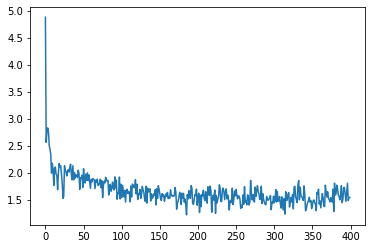

In [11]:
hidden_size = 256
encoder1 = Encoder(input_dict.n_tokens, hidden_size).to(device)
#decoder1 = Decoder(hidden_size, target_dict.n_tokens).to(device)
decoder1 = AttnDecoder(hidden_size, target_dict.n_tokens, dropout_p=0.1).to(device)

train_iterations(encoder1, decoder1, n_iterations=40000, print_every=500, learning_rate=0.001)